In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
%cd ../scripts/
import sys
import os
sys.path.append("../")
sys.path.append("../Modules")
import analysis

/home/drfrbc/Neural-Modeling/scripts


In [ ]:
# # provide a simulations folder (choose among the set)
# simulations_dir = "/home/drfrbc/Neural-Modeling/scripts/2025-04-01-14-14-Running_5sec_STA_noRhyth"
# sim_index = input(f"Specify the simulation index (0-{len(os.listdir(simulations_dir))-1}): from among simulations {os.listdir(simulations_dir)}")
# sim_directory = os.path.join(simulations_dir, os.listdir(simulations_dir)[int(sim_index)])


# OR provide a simulation folder
sim_directory = "/home/drfrbc/Neural-Modeling/scripts/2025-04-16-10-43-L5_Testing_Seeding_inc_tuft_inh_dens/tuning_Complex_DepthPeriInh0.0150_DepthDistalInh0.0150_InhTuftDensity0.2200_0.4400_0.3850_0.0572_0.2200_0.1650_ExcTuftDensity2.1600_2.1600_2.1600_2.1600_2.1600_Np5000"

In [5]:
# Generate .csv's for dendritic events
!python find_events_ben.py -d {sim_directory}

--No graphics will be displayed.
Traceback (most recent call last):
  File "/home/drfrbc/Neural-Modeling/scripts/find_events_ben.py", line 328, in <module>
    compute_dfs(sim_directory, ben)
  File "/home/drfrbc/Neural-Modeling/scripts/find_events_ben.py", line 299, in compute_dfs
    na, hva, lva, ih, nmda, v, spkinds, segs = load_data(sim_directory, ben)
  File "/home/drfrbc/Neural-Modeling/scripts/find_events_ben.py", line 107, in load_data
    na = analysis.DataReader.read_data(sim_directory, "gNaTa_t_NaTa_t").T
  File "/home/drfrbc/Neural-Modeling/Modules/analysis.py", line 36, in read_data
    with h5py.File(os.path.join(sim_folder, f"saved_at_step_{step}", sim_file_name + ".h5"), 'r') as file:
  File "/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/h5py/_hl/files.py", line 562, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/drfrbc/miniconda3/envs/sim_env/lib/python3.10/site-packages/h5py/_hl/files.py", line 235,

In [ ]:
print(f"Loading data from {sim_directory}")

def load_sim(sim_directory, vars_to_load=['v', 'spktimes', 'spkinds']): #TODO: move this to its own module, include list of variables for generating sim_data
    # load parameters
    parameters = analysis.DataReader.load_parameters(sim_directory)

    # load recorded data
    sim_data = {
        'v': analysis.DataReader.read_data(sim_directory, "v").T,
        # 'hva': analysis.DataReader.read_data(sim_directory, "ica_Ca_HVA").T,
        # 'lva': analysis.DataReader.read_data(sim_directory, "ica_Ca_LVAst").T,
        # 'ih': analysis.DataReader.read_data(sim_directory, "ihcn_Ih").T,
        # 'nmda': analysis.DataReader.read_data(sim_directory, "i_NMDA").T,
        # 'na': analysis.DataReader.read_data(sim_directory, "gNaTa_t_NaTa_t").T,
        'spktimes': analysis.DataReader.read_data(sim_directory, "soma_spikes")[0][:],
        'spkinds': np.sort((analysis.DataReader.read_data(sim_directory, "soma_spikes")[0][:] * 10).astype(int)),
        # 'na_df': pd.read_csv(os.path.join(sim_directory, 'na.csv')),
        # 'ca_df': pd.read_csv(os.path.join(sim_directory, 'ca.csv')),
        # 'nmda_df': pd.read_csv(os.path.join(sim_directory, 'nmda.csv'))
    }

    # load segment information
    seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))
    seg_data['Sec ID'] = seg_data['idx_in_section_type']
    seg_data['Type'] = seg_data['section']
    seg_data['Coord X'] = seg_data['pc_0']
    seg_data['Coord Y'] = seg_data['pc_1']
    seg_data['Coord Z'] = seg_data['pc_2']
    elec_dist = pd.read_csv(os.path.join(sim_directory, f"elec_distance_{'soma'}.csv"))
    seg_data['Elec_distance'] = elec_dist['25_active']
    elec_dist = pd.read_csv(os.path.join(sim_directory, f"elec_distance_{'nexus'}.csv"))
    seg_data['Elec_distance_nexus'] = elec_dist['25_active']
    Xs = []
    for seg in seg_data['seg']:
        Xs.append(seg.split('(')[-1].split(')')[0])
    seg_data['X'] = Xs

    # continue
    seg_data['segmentID'] = seg_data.index

    seg_data['Sec ID'] = seg_data['Sec ID'].astype(int)
    seg_data['X'] = seg_data['X'].astype(float)
    seg_data['Elec_distanceQ'] = 'None'

    seg_data.loc[seg_data.Type=='dend','Elec_distanceQ'] = pd.qcut(seg_data.loc[seg_data.Type=='dend','Elec_distance'], 10, labels=False)
    seg_data.loc[seg_data.Type=='apic','Elec_distanceQ'] = pd.qcut(seg_data.loc[seg_data.Type=='apic','Elec_distance'], 10, labels=False)
    return parameters, sim_data, seg_data, elec_dist

parameters, sim_data, seg_data, elec_dist = load_sim(sim_directory)

Loading data from /home/drfrbc/Neural-Modeling/scripts/2025-04-16-10-43-L5_Testing_Seeding_inc_tuft_inh_dens/tuning_Complex_DepthPeriInh0.0150_DepthDistalInh0.0150_InhTuftDensity0.2200_0.4400_0.3850_0.0572_0.2200_0.1650_ExcTuftDensity2.1600_2.1600_2.1600_2.1600_2.1600_Np5000


--No graphics will be displayed.


In [12]:
if not os.path.exists(os.path.join(sim_directory, "voltages")):
    os.makedirs(os.path.join(sim_directory, "voltages"))

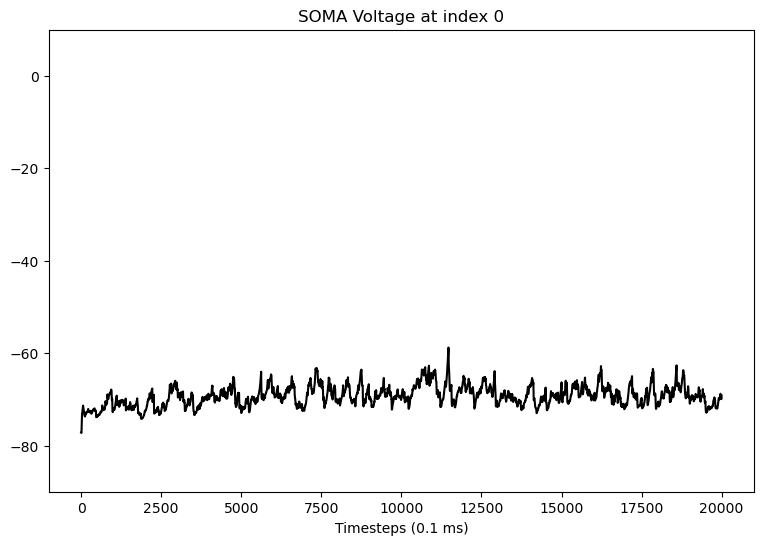

In [ ]:
# plot soma voltage
time_points=np.arange(0,int(parameters.h_tstop/parameters.h_dt))
time_points = time_points[0:19999] # select time_points
# time_points = time_points[100000:149999]
# time_points = time_points[450000:499999]
colors = ['r*', 'g*', 'b*', 'm*', 'y*', 'k*']
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 2)
plt.plot(sim_data['v'][time_points, 0], colors[-1].split('*')[0])
plt.ylim([-90, 10])
plt.title(f'SOMA Voltage at index {0}')
plt.xlabel(f'Timesteps ({parameters.h_dt} ms)')
# plt.xlim(40000,50000)
plt.savefig(os.path.join(sim_directory, 'voltages', 'soma_voltage_init.png'), format='png', bbox_inches="tight", dpi=300)
# plt.show()

In [14]:
# spike rate

# Function to count the first occurrence of True in consecutive trues
def count_first_true(arr):
    return np.sum((arr > -10) & np.concatenate(([True], arr[:-1] <= -10)))

# Count the number of spikes in the soma
soma_spike_count = count_first_true(sim_data['v'][:, 0])
print(f"Soma spike count {soma_spike_count}")
sim_duration = len(sim_data['v'][:, 0])
print(f"Simulation duration in timesteps: {sim_duration}")
sim_duration_in_sec = sim_duration / ((1/parameters.h_dt) * 1000)
print(f"Simulation duration in seconds: {sim_duration_in_sec}")
soma_spike_rate = soma_spike_count / (len(sim_data['v'][:, 0]) / 10000)
print(f"Soma firing rate {round(soma_spike_rate, 3)}")

Soma spike count 0
Simulation duration in timesteps: 50001
Simulation duration in seconds: 5.0001
Soma firing rate 0.0


In [ ]:
# seg_data.columns

Index(['Unnamed: 0', 'section', 'idx_in_section_type', 'seg_half_seg_RA', 'L',
       'seg', 'pseg', 'Section_L', 'Section_diam', 'Distance', 'p0_0', 'p0_1',
       'p0_2', 'pc_0', 'pc_1', 'pc_2', 'p1_0', 'p1_1', 'p1_2', 'r', 'dl_0',
       'dl_1', 'dl_2', 'Sec ID', 'Type', 'Coord X', 'Coord Y', 'Coord Z',
       'Elec_distance', 'Elec_distance_nexus', 'X', 'segmentID',
       'Elec_distanceQ'],
      dtype='object')

In [ ]:
# parameters

HayParameters(sim_name='tuning_Complex_DepthPeriInh0.0150_DepthDistalInh0.0150_InhTuftDensity0.2200_0.4400_0.3850_0.0572_0.2200_0.1650_ExcTuftDensity2.1600_2.1600_2.1600_2.1600_2.1600_Np5000', morphology_name='Complex', sim_type='tuning', us_allen_cell=False, numpy_random_state=5000, neuron_random_state=90, h_celcius=37, h_tstop=5000, h_dt=0.1, h_v_init=-77.2, CI_on=False, CI_target='soma', h_i_amplitude=10.0, h_i_duration=1000, h_i_delay=10, record_ecp=False, record_seg_to_seg=False, all_synapses_off=False, trunk_exc_synapses=True, perisomatic_exc_synapses=True, add_soma_inh_synapses=True, bin_exc_gmax=False, exc_use_density=True, inh_use_density=True, use_SA_probs=False, exc_syn_properties={'tuft': {'syn_density': 2.16, 'syn_number': 3264.0, 'gmax_params': {'mean': 0.42, 'std': 0.09675, 'clip': (0, 2), 'scalar': 1}, 'seed': {'synapses': 3333333}}, 'nexus': {'syn_density': 2.16, 'syn_number': 3264.0, 'gmax_params': {'mean': 0.42, 'std': 0.09675, 'clip': (0, 1.5), 'scalar': 1}, 'seed':

In [ ]:
# np.shape(sim_data['v']) # should be (times, segments)

(50001, 2630)

In [ ]:
# sim_data['v'][:, 0] # get soma voltage over time

array([-77.2       , -77.22396043, -77.24381223, ..., -71.9365333 ,
       -71.99500499, -72.01369385])

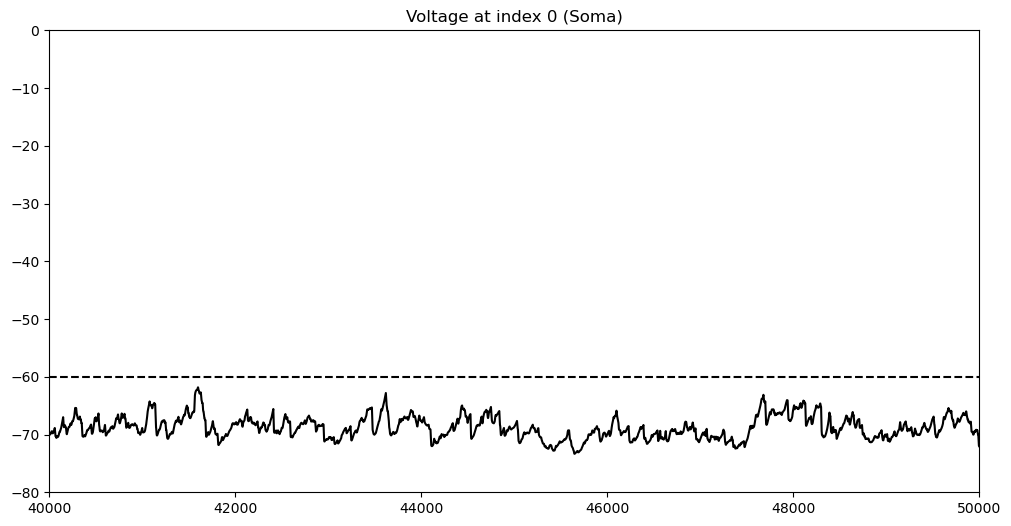

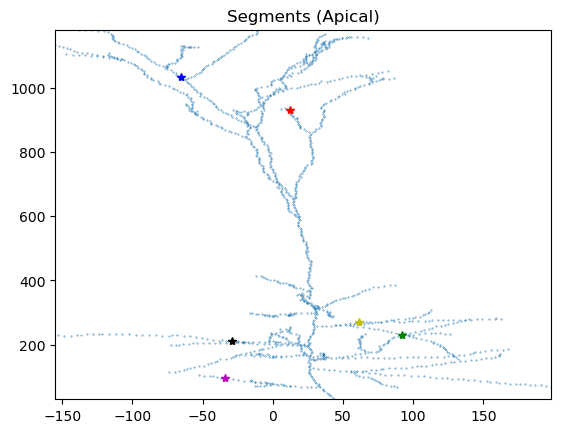

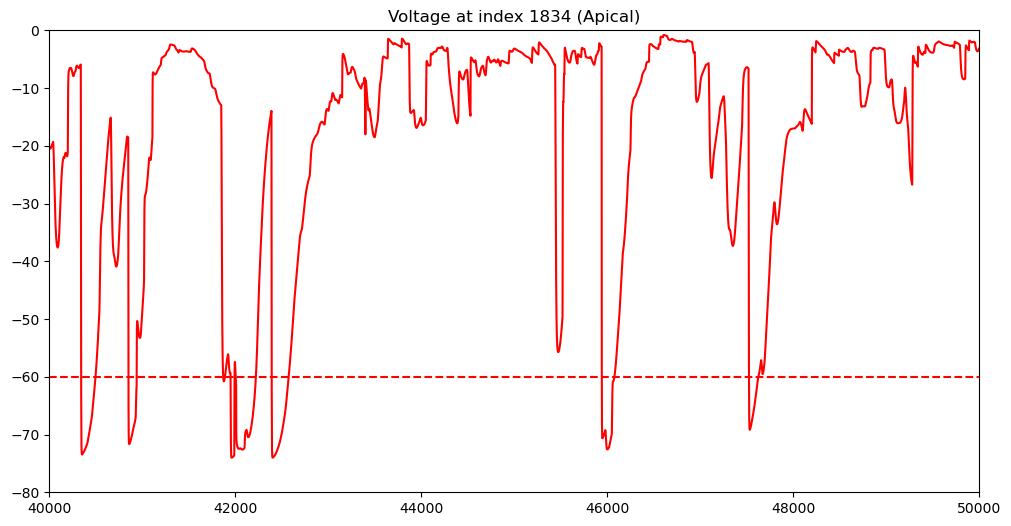

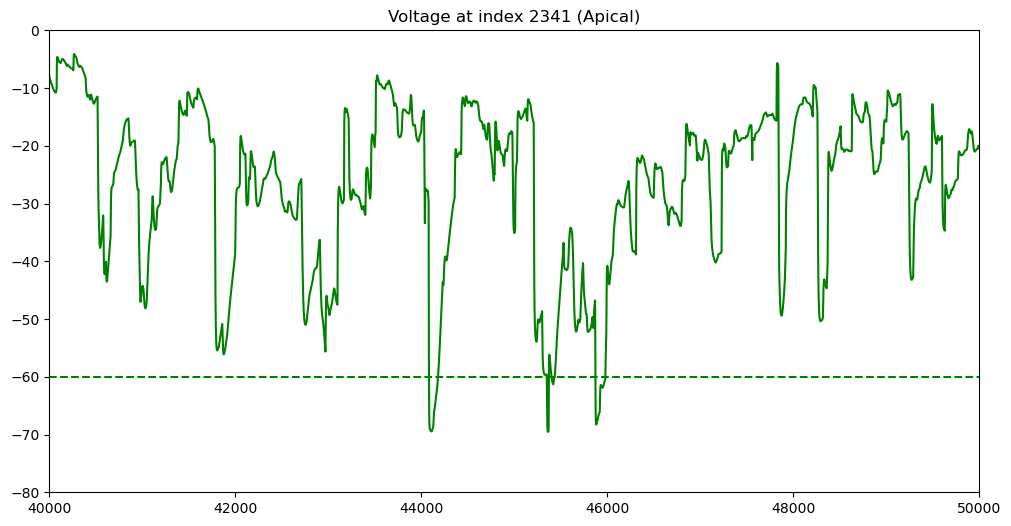

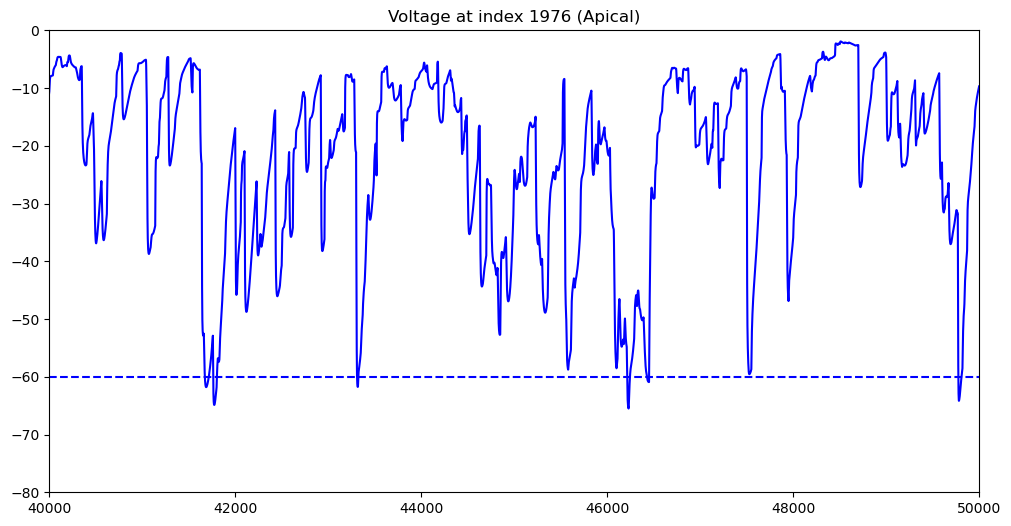

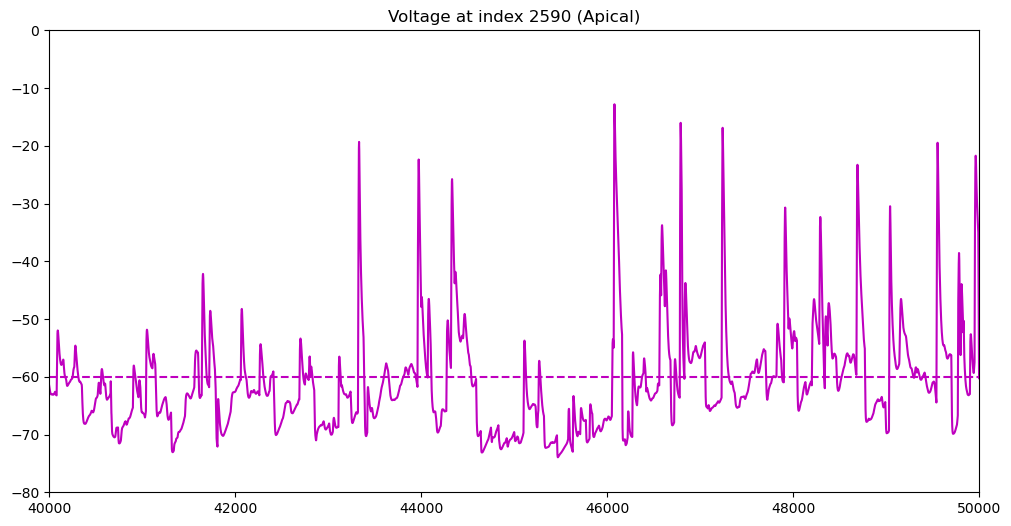

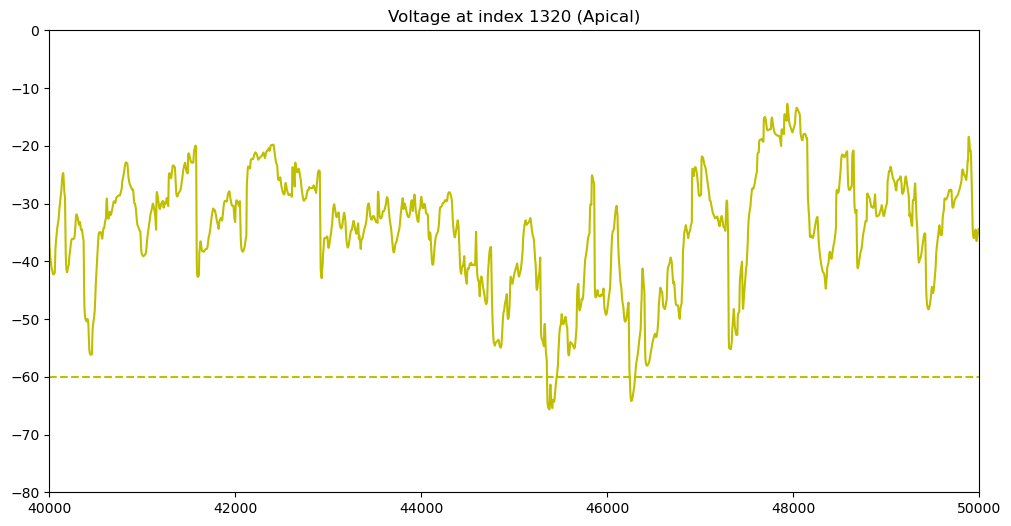

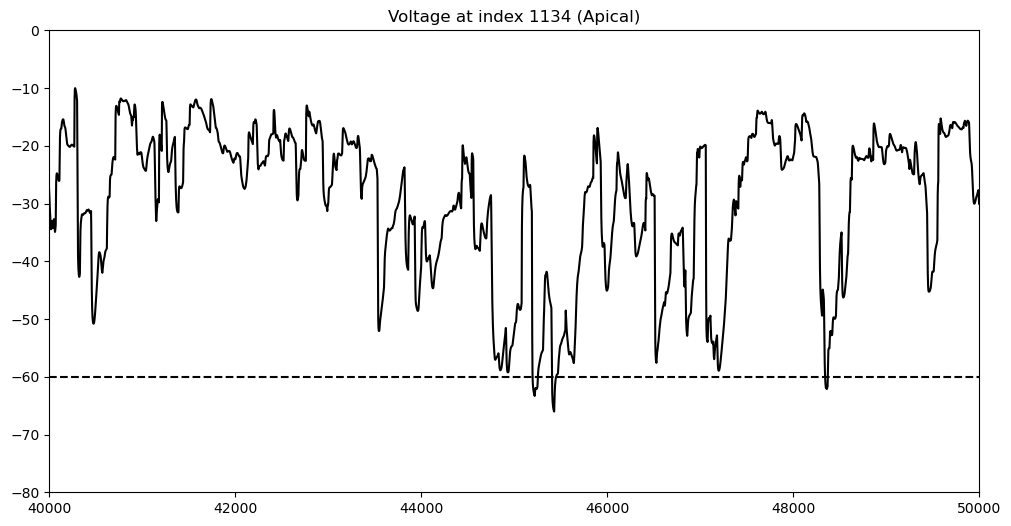

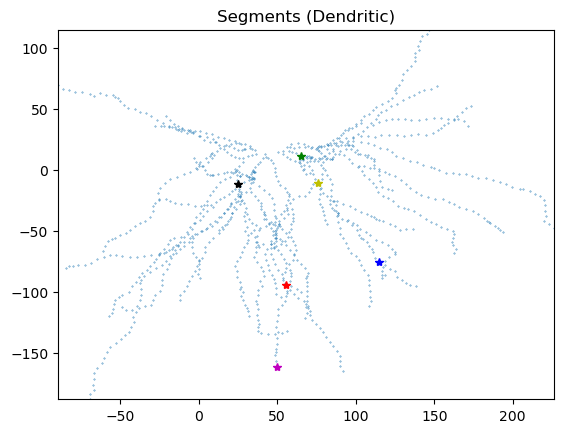

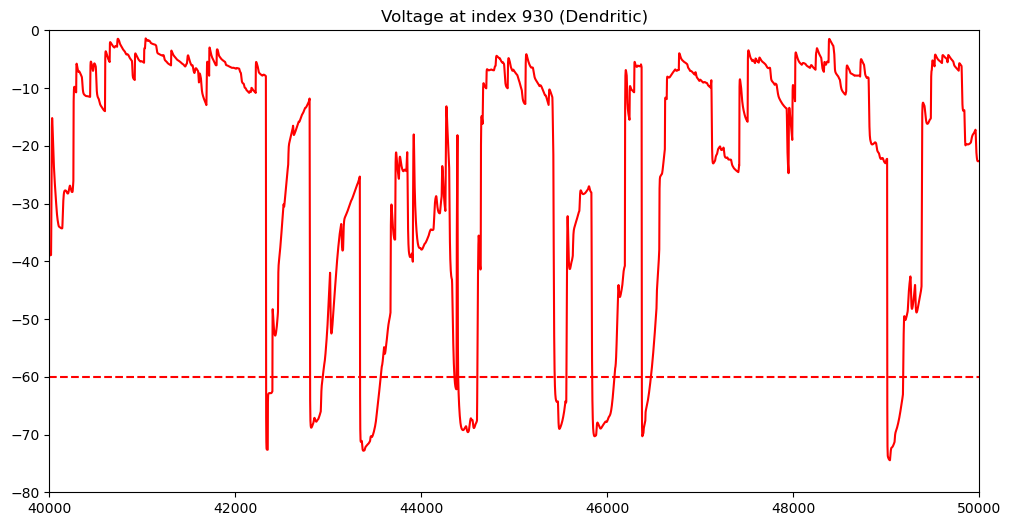

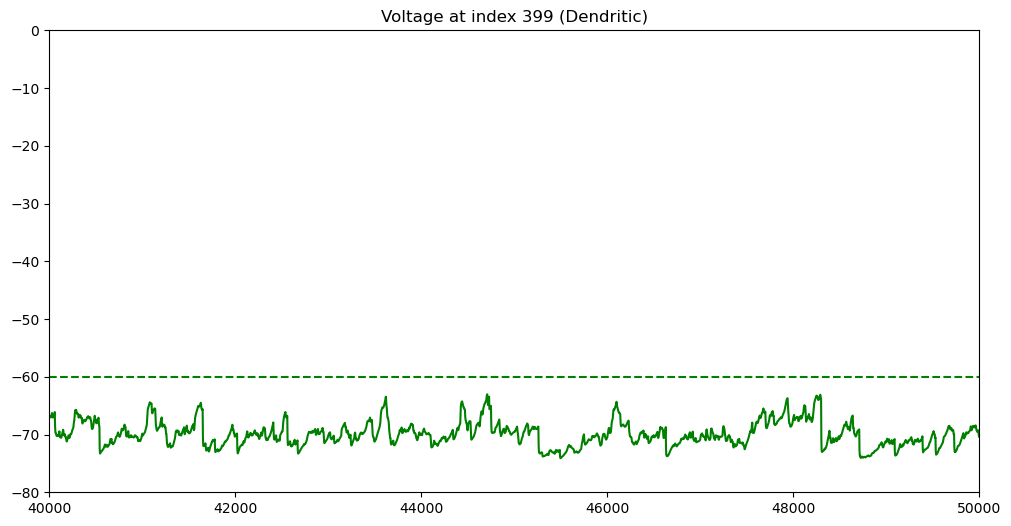

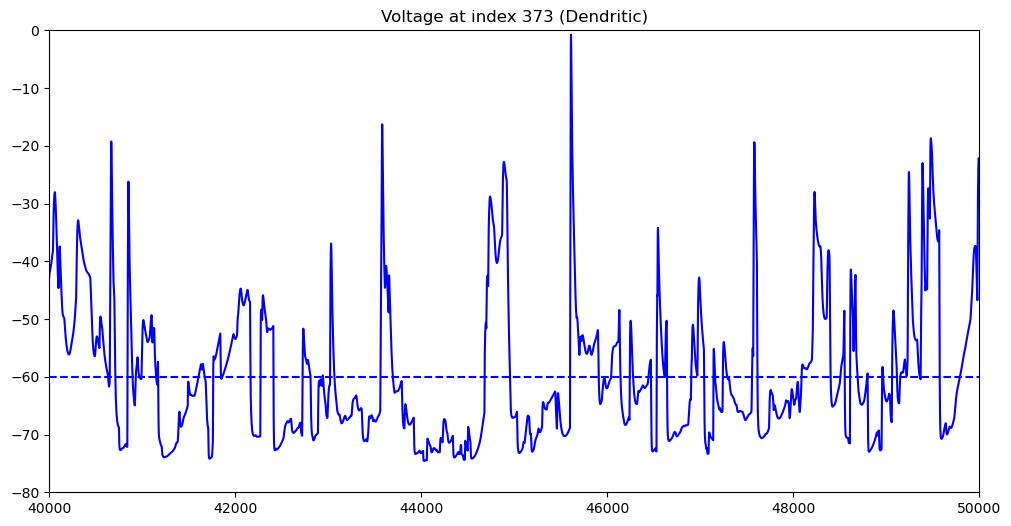

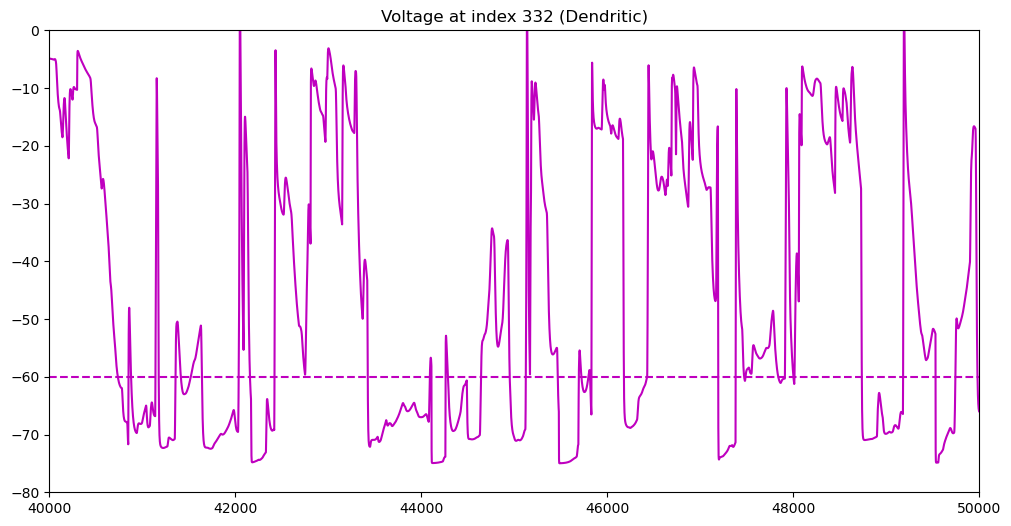

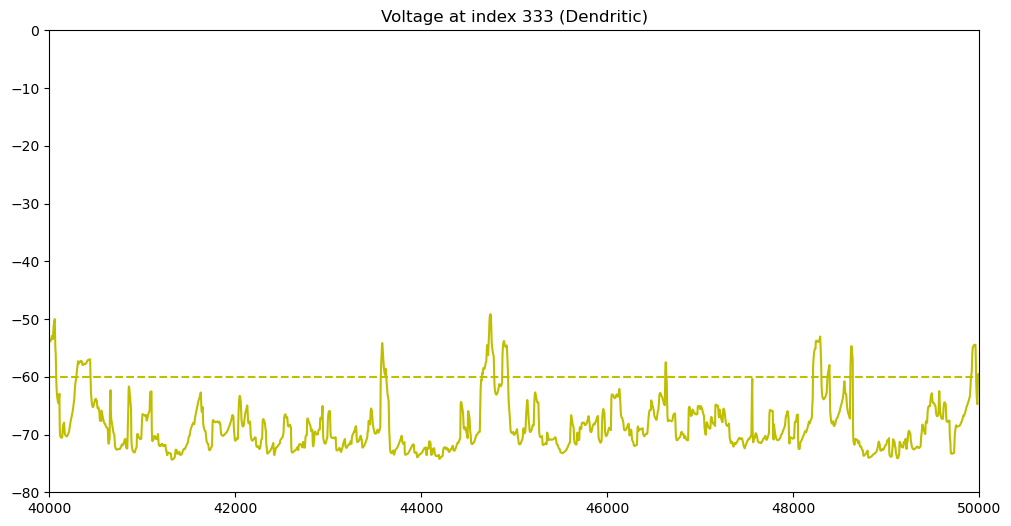

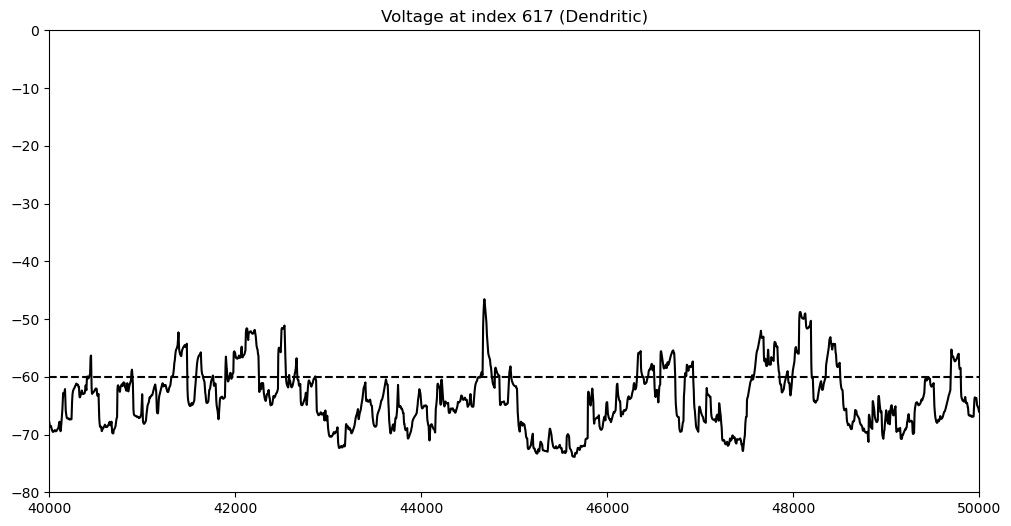

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# xlimits = [100000,110000]
# plt.figure(figsize=(20, 6))

# plt.subplot(1, 2, 2)
# plt.plot(sim_data['v'][:, 0], colors[-1].split('*')[0])
# plt.ylim([-90, 10])
# plt.title(f'SOMA Voltage at index {0}')
# plt.xlabel(f'Timesteps ({parameters.h_dt} ms)')
# plt.xlim(xlimits)
# plt.savefig(os.path.join(sim_directory, 'soma_voltage.png'), format='png', bbox_inches="tight", dpi=300)

from Modules.plot_morphology import plot_segments
from Modules.plot_voltage import plot_voltage

# Filter for specific segment types
soma_segs= seg_data[seg_data['Type']=='soma']
soma_indices = [soma_segs.segmentID[0]]
colors =['k*']
plot_voltage(sim_data, soma_indices, colors, xlims = [40000,50000], title_suffix="(Soma)", save_file=os.path.join(sim_directory, 'voltages', 'soma_voltage'), show=True)

# Filter for specific segment types
apic_segs= seg_data[seg_data['Type']=='apic']

# Plot segments
# apic_indices = [1500, 1400, 1900, 2000, 2500, 1800]
apic_indices = np.random.choice(apic_segs.segmentID, 6)
# apic_indices = [1402, 1203, 1842, 1533, 1545, 1887, 2000, 1700, 1250, 1210, 1340]
# apic_indices = [1842, 1780, 1210, 1340, 1080]
# apic_indices = [1842, 1780, 1210, 1080]
# apic_indices = [1842, 1782, 1210, 1080]
# apic_indices = [2000, 1910]
# apic_indices = [1749,  656, 1618,  639,  571, 1737] # reduced
# apic_indices = np.array([441, 394, 342, 307, 415, 267]) # L2/3
colors = ['r*', 'g*', 'b*', 'm*', 'y*', 'k*']
# apic_indices = np.arange(1200, 2550, 50)
# apic_indices = [2400]

# colors = ['r*', 'g*', 'b*', 'm*', 'y*', 'k*']* 20
# apic_indices = [656, 571, 1618, min(apic_segs.segmentID)+3] # reduced
# colors = ['r*', 'g*', 'b*', 'm*'] # reduced
plot_segments(apic_segs, apic_indices, colors, title_suffix="(Apical)", save_file=os.path.join(sim_directory, 'voltages', 'apic_segs'), show=True)

# Plot voltage
plot_voltage(sim_data, apic_indices, colors, xlims = [40000,50000], title_suffix="(Apical)", save_file=os.path.join(sim_directory, 'voltages', 'apical_voltages'), show=True)

# Now for dendritic segments
dend_segs = seg_data[seg_data['Type']=='dend']

# Plot segments
# dend_indices = [10, 20, 30, 40, 50, 60]
# dend_indices = np.arange(10, 1000, 50)
dend_indices = np.random.choice(dend_segs.segmentID, 6)
# dend_indices = [326]# [288]
# dend_indices = [340]
# colors = ['y*']
# dend_indices = [689, 220, 635, 186, 777, 720]
# dend_indices = [1485, 1178, 1529, 1331,  807, 1145] # reduced
# dend_indices = [1346] # reduced
# dend_indices = np.array([236, 163, 213, 168, 200,  40]) # L2/3
# colors = ['r*', 'g*', 'b*', 'm*', 'y*', 'k*']* 20
plot_segments(dend_segs, dend_indices, colors, title_suffix="(Dendritic)", save_file=os.path.join(sim_directory, 'basal_segs'), show=True)

# Plot voltage
plot_voltage(sim_data, dend_indices, colors, xlims = [40000,50000], title_suffix="(Dendritic)", save_file=os.path.join(sim_directory, 'basal_voltages'), show=True)

In [21]:
dend_indices

array([930, 399, 373, 332, 333, 617])

In [ ]:
# # generate figures for all simulations in a given simulations_dir

# for sim_dir in os.listdir(simulations_dir):
#     sim_directory = os.path.join(simulations_dir, sim_dir)
#     if not os.path.exists(os.path.join(sim_directory, 'parameters.pickle')):
#         continue

#     parameters, sim_data, seg_data, elec_dist = load_sim(sim_directory)
#     plot_segments(apic_segs, apic_indices, colors, title_suffix="(Apical)", save_file=os.path.join(sim_directory, 'apic_segs'), show=False)

#     # Plot voltage
#     plot_voltage(sim_data, apic_indices, colors, title_suffix="(Apical)", save_file=os.path.join(sim_directory, 'apical_voltages'), show=False)

#     # Now for dendritic segments
#     dend_segs = seg_data[seg_data['Type']=='dend']

#     # Plot segments
#     # dend_indices = [10, 20, 30, 40, 50, 60]
#     # dend_indices = np.arange(10, 1000, 50)
#     # dend_indices = np.random.choice(dend_segs.segmentID, 6)
#     # dend_indices = [689, 220, 635, 186, 777, 720]
#     plot_segments(dend_segs, dend_indices, colors, title_suffix="(Dendritic)", save_file=os.path.join(sim_directory, 'basal_segs'), show=False)

#     # Plot voltage
#     plot_voltage(sim_data, dend_indices, colors, title_suffix="(Dendritic)", save_file=os.path.join(sim_directory, 'basal_voltages'), show=False)

## Mark dSpikes

In [23]:
# plot scatter for dspikes
def plot_spike_times(spike_dfs: dict, seg_id):
    spike_start_times = ca_df[ca_df['segmentID'] == seg_id_to_plot].ca_lower_bound
    spike_start_times_to_use = spike_start_times[(spike_start_times < end_step) & (spike_start_times > start_step)]
    spike_start_times_to_use = np.array(spike_start_times_to_use).astype(int)
    

In [24]:
start_step = 50000
end_step = 60000
t = np.arange(0, (parameters.h_tstop)+parameters.h_dt, parameters.h_dt)

[1842, 1780, 1210, 1080]
plot_specs = { # organize these from near soma to far from soma.
    # 'nexus': {
    #     'seg_ids_to_plot':[1910],#[2000],#[1794], # [1545], # Complex
    #     # 'seg_ids_to_plot': [299], # Reduced
    #     'spike_types_to_plot': ['Ca'],
    #     'color': 'green'
    #     },
    # 'distal_tuft': {
    #     'seg_ids_to_plot':[2000],#[1844],#[1700, 1887, 2000], # Complex
    #     # 'seg_ids_to_plot': [736],
    #     'spike_types_to_plot': ['nmda', 'na'],
    #     'color': 'red'
    # },
    # 'mid_tuft': {
    #     # 'seg_ids_to_plot': [], # Complex
    #     'seg_ids_to_plot': [453, 599], # Reduced
    #     'spike_types_to_plot': ['nmda', 'na'],
    #     'color': 'blue'
    # },
    'basal': {
        'seg_ids_to_plot': [326], # Complex
        # 'seg_ids_to_plot': [1066], # Reduced
        'spike_types_to_plot': ['nmda', 'na'],
        'color': 'yellow'
    },
    # 'dist_basal': {
    #     # 'seg_ids_to_plot': [], # Complex
    #     'seg_ids_to_plot': [1220, 1103], # Reduced
    #     'spike_types_to_plot': ['nmda', 'na'],
    #     'color': 'blue'
    # # },
    # 'middle_oblique': {
    #     'seg_ids_to_plot': [1210],#[1300] # Complex
    #     # 'seg_ids_to_plot': [1727] # reduced
    #     'spike_types_to_plot': ['nmda', 'na'],
    #     'color': 'blue'
    # },
    # # 'dist_oblique': {
    # #     # 'seg_ids_to_plot': [], # Complex
    # #     'seg_ids_to_plot': [1612], # Reduced
    # #     'spike_types_to_plot': ['nmda', 'na'],
    # #     'color': 'blue'
    # # },
    # 'dist_trunk': {
    #     # 'seg_ids_to_plot': [], # Complex
    #     'seg_ids_to_plot': [201], # Reduced
    #     'spike_types_to_plot': ['nmda', 'na'],
    #     'color': 'blue'
    # },
}

plot_soma_spike_times = True

if parameters.record_all_channels:
    for region, region_params in plot_specs.items():
        # pick the segment indices
        # seg_id_to_plot = 1545
        for seg_id_to_plot in region_params['seg_ids_to_plot']:
            # mark them on morphology (can use above)

            # read the csvs at the desired segments
            ca_df = pd.read_csv(os.path.join(sim_directory,"ca.csv"))

            spike_start_times = ca_df[ca_df['segmentID'] == seg_id_to_plot].ca_lower_bound
            spike_start_times_to_use = spike_start_times[(spike_start_times < end_step) & (spike_start_times > start_step)]
            spike_start_times_to_use = np.array(spike_start_times_to_use).astype(int)


            plt.figure(figsize=(20,8))
            # plot voltage of the segment and mark spike times
            plt.plot(t[start_step:end_step], sim_data['v'][start_step:end_step, seg_id_to_plot], color = region_params['color'])
            
            plt.scatter(t[spike_start_times_to_use], sim_data['v'][spike_start_times_to_use, seg_id_to_plot], marker='*', color='green')

            if plot_soma_spike_times:
                soma_spike_times_to_plot = sim_data['spktimes'][np.array(sim_data['spktimes'] < max(t[start_step:end_step])) & np.array(sim_data['spktimes'] > min(t[start_step:end_step]))]
                for event_time in soma_spike_times_to_plot:
                    plt.axvline(event_time, linestyle='--', color='grey')

            # plot end times
            spike_start_times = ca_df[ca_df['segmentID'] == seg_id_to_plot].ca_upper_bound
            spike_start_times_to_use = spike_start_times[(spike_start_times < end_step) & (spike_start_times > start_step)]
            spike_start_times_to_use = np.array(spike_start_times_to_use).astype(int)

            plt.scatter(t[spike_start_times_to_use], sim_data['v'][spike_start_times_to_use, seg_id_to_plot], marker='*', color='red')

            plt.xlabel('Time (ms)')
            plt.title(f"Ca spikes {region} seg: {seg_id_to_plot} ")
            save_file = os.path.join(sim_directory, f"{region}_Ca_spikes")
            plt.savefig(f"{save_file}_{seg_id_to_plot}.png", format='png', bbox_inches="tight", dpi=300)

            ### NMDA
            nmda_df = pd.read_csv(os.path.join(sim_directory, "nmda.csv"))

            spike_start_times = nmda_df[nmda_df['segmentID'] == seg_id_to_plot].nmda_lower_bound
            spike_start_times_to_use = spike_start_times[(spike_start_times < end_step) & (spike_start_times > start_step)]
            spike_start_times_to_use = np.array(spike_start_times_to_use).astype(int)

            plt.figure(figsize=(20,8))
            # plot voltage of the segment and mark spike times
            plt.plot(t[start_step:end_step], sim_data['v'][start_step:end_step, seg_id_to_plot], color = region_params['color'])
            plt.scatter(t[spike_start_times_to_use], sim_data['v'][spike_start_times_to_use, seg_id_to_plot], marker='*', color='green')
            # plot end times
            spike_start_times = nmda_df[nmda_df['segmentID'] == seg_id_to_plot].nmda_upper_bound
            spike_start_times_to_use = spike_start_times[(spike_start_times < end_step) & (spike_start_times > start_step)]
            spike_start_times_to_use = np.array(spike_start_times_to_use).astype(int)
            plt.scatter(t[spike_start_times_to_use], sim_data['v'][spike_start_times_to_use, seg_id_to_plot], marker='*', color='red')
            plt.xlabel('Time (ms)')
            plt.title(f"NMDA spikes {region} seg: {seg_id_to_plot}")
            save_file = os.path.join(sim_directory, f"{region}_NMDA_spikes")
            plt.savefig(f"{save_file}_{seg_id_to_plot}.png", format='png', bbox_inches="tight", dpi=300)

            ## Na
            na_df = pd.read_csv(os.path.join(sim_directory, "na.csv"))

            spike_start_times = na_df[na_df['segmentID'] == seg_id_to_plot].na_lower_bound
            spike_start_times_to_use = spike_start_times[(spike_start_times < end_step) & (spike_start_times > start_step)]
            spike_start_times_to_use = np.array(spike_start_times_to_use).astype(int)

            plt.figure(figsize=(20,8))
            # plot voltage of the segment and mark spike times
            plt.plot(t[start_step:end_step], sim_data['v'][start_step:end_step, seg_id_to_plot], color = region_params['color'])
            plt.scatter(t[spike_start_times_to_use], sim_data['v'][spike_start_times_to_use, seg_id_to_plot], marker='*', color='green')
            plt.title(f"Na spikes {region} seg: {seg_id_to_plot}")
            save_file = os.path.join(sim_directory, f"{region}_Na_spikes")
            plt.savefig(f"{save_file}_{seg_id_to_plot}.png", format='png', bbox_inches="tight", dpi=300)
            # # plot end times
            # spike_start_times = na_df[na_df['segmentID'] == seg_id_to_plot].na_upper_bound
            # spike_start_times_to_use = spike_start_times[(spike_start_times < end_step) & (spike_start_times > start_step)]
            # spike_start_times_to_use = np.array(spike_start_times_to_use).astype(int)
            # plt.scatter(t[spike_start_times_to_use], sim_data['v'][spike_start_times_to_use, seg_id_to_plot], marker='*', color='red')
            # plt.xlabel('Time (ms)')

In [25]:
np.shape(sim_data['v'])

(50001, 2630)

In [26]:
ca_df[ca_df['segmentID'] == 1900].ca_lower_bound

NameError: name 'ca_df' is not defined

## calculate average voltage of each segment type

In [ ]:
sim_data['v'].shape

In [ ]:
seg_mean_vs = []
for i, seg in seg_data.iterrows():
    seg_mean_v = np.mean(sim_data['v'][:,i])
    seg_mean_vs.append(seg_mean_v)

In [ ]:
seg_data['mean_v'] = seg_mean_vs

In [ ]:
seg_data

In [ ]:
elec_dist_to_plot = seg_data['Elec_distance'][np.argsort(seg_data['Elec_distance'])]
avg_v_to_plot = seg_data['mean_v'][np.argsort(seg_data['Elec_distance'])]

plt.scatter(elec_dist_to_plot, avg_v_to_plot)
plt.ylabel('mean voltage')
plt.xlabel('segment transfer ratio from soma (1 is soma)')

In [ ]:
[min(seg_data['mean_v']), max(seg_data['mean_v'])]

In [ ]:
sim_directory

In [ ]:
from Modules import plot_morphology
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# plot_morphology.plot(seg_data,  seg_data['mean_v'], ax, clims = [min(seg_data['mean_v']), max(seg_data['mean_v'])], radius_scale=1.5)
fig = plot_morphology.plot(seg_data,  seg_data['mean_v'], ax, clims = [-80, -10], radius_scale=1.5)
ax.clabel('mean voltage')
plt.savefig(os.path.join(sim_directory, 'mean_v_morphology'))

## Calculate FFT of voltage to look for artifcats from rhythmic inhibition

In [ ]:
# check PSD

from scipy.signal import welch
signal = sim_data['v'][:,0] #1644

# Compute PSD using Welch's method
f, Pxx = welch(signal, fs=10000, nperseg=10000)

Pxx = Pxx[f<100]
f=f[f<100]

# Plot the result
# plt.subplots(1,2)
# plt.subplot(121)
# plt.plot(signal)

# plt.subplot(122)
plt.semilogy(f, Pxx)
plt.scatter(f[f-16==min(abs(f-16))], Pxx[f-16==min(abs(f-16))], c='r', label=f'{f[f-16==min(abs(f-64))]} Hz')
plt.scatter(f[abs(f-64)==min(abs(f-64))], Pxx[abs(f-64)==min(abs(f-64))], c='orange', label=f'{f[abs(f-64)==min(abs(f-64))]} Hz')
# plt.semilogy(f, 100/f)
plt.title('Power Spectral Density using Welch\'s Method')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
f[f-16==min(abs(f-16))]

In [ ]:
f

In [ ]:

f[Pxx == max(Pxx)]

Spike raster

In [ ]:
# read synapse_data.h5 from our simulations.
def read_synapse_distribution_file(sim_directory):
    """
    Reads the synapse_data.h5 file and loads its datasets into a Pandas DataFrame.

    Parameters:
        sim_directory (str): Path to the directory containing synapse_data.h5.

    Returns:
        pd.DataFrame: A DataFrame where each column corresponds to a dataset in the HDF5 file.
    """
    # Construct the full file path
    synapse_file_path = os.path.join(sim_directory, 'synapse_data.h5')

    # Check if the file exists
    if not os.path.exists(synapse_file_path):
        raise FileNotFoundError(f"File not found: {synapse_file_path}")

    # Dictionary to temporarily store the data
    synapse_data = {}

    # Read the HDF5 file
    with h5py.File(synapse_file_path, 'r') as h5f:
        # Load all datasets into the dictionary
        for key in h5f.keys():
            synapse_data[key] = h5f[key][()]  # Load dataset into memory as NumPy array

    # Convert the dictionary into a Pandas DataFrame
    synapse_df = pd.DataFrame(synapse_data)

    return synapse_df

def read_transfer_impedance_file(sim_directory, loc='soma'):
    # loc can be nexus
    imp_file = os.path.join(sim_directory, f"elec_distance_{loc}.csv")
    impedance_data = pd.read_csv(imp_file)
    return impedance_data

def add_seg_info_to_syn_data(syn_data, seg_data):
    """
    Adds segment information (Distance and section) from seg_data to syn_data
    using the seg_id as a lookup.

    Parameters:
        syn_data (pd.DataFrame): DataFrame containing synapse data with 'seg_id'.
        seg_data (pd.DataFrame): DataFrame containing segment data.

    Returns:
        pd.DataFrame: Updated syn_data with 'Distance' and 'section' columns added.
    """
    # Set 'Unnamed: 0' as the index in seg_data for easy lookup
    seg_data_indexed = seg_data.set_index('Unnamed: 0')

    # Use .loc to map the segment information to syn_data based on seg_id
    syn_data['Distance'] = syn_data['seg_id'].map(seg_data_indexed['Distance'])
    syn_data['section'] = syn_data['seg_id'].map(seg_data_indexed['section'])
    syn_data['soma_trans_imp'] = syn_data['seg_id'].map(seg_data_indexed['soma_trans_imp'])
    syn_data['seg_L'] = syn_data['seg_id'].map(seg_data_indexed['L'])

    # Convert the 'synapse_type' column from bytes to strings

# read synapses from our simulation and ben's
syn_data = read_synapse_distribution_file(sim_directory)

# read segment data from our simulation
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

# read transfer impedances
imp_df = read_transfer_impedance_file(sim_directory, loc='soma')
seg_data['soma_trans_imp'] = imp_df.beta_active

# add segment information of synapse location
# syn_data = add_seg_info_to_syn_data(syn_data, seg_data)

In [ ]:
print(syn_data)

In [ ]:
syn_data